# IT1244 Project

## Import Libraries

In [4]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer, BertTokenizerFast
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [7]:
def accuracy_score(y_test, y_pred):
    return sum(y_test == y_pred)/len(y_test)

## Data Importing

In [8]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header=None)
tweets.head()

,0,1
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Bert Encoding

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')

In [ ]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


In [ ]:
sentence_vectors = tweets[1].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))
data_frame = pd.DataFrame(data)
data_frame.to_csv("../Data/Cleaned/BERT_Vectors.csv")

### Read the CSV data file

In [9]:
Bert_Encoded_Text = pd.read_csv("../Data/Cleaned/BERT_Vectors.csv").iloc[: , 1:]
X = Bert_Encoded_Text
y = tweets[0]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Model

In [20]:
clf = RandomForestClassifier(max_depth=5, min_samples_split=10, random_state=42)
RFC = clf.fit(X_train, y_train)
y_hat = RFC.predict(X_test)

In [17]:
accuracy_score(y_test, y_hat)

0.6851

### K-NN Model

#### N-fold Cross validation

In [21]:
k_values = [i for i in range(1, 50, 2)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

KeyboardInterrupt: 

In [ ]:
results = list(map(lambda x: float(x), scores))

In [ ]:
results

[0.65648,
 0.64578,
 0.67612,
 0.6713899999999999,
 0.68684,
 0.68375,
 0.69182,
 0.6899200000000001,
 0.69536,
 0.69342,
 0.69888,
 0.6965199999999999,
 0.69996,
 0.6984300000000001,
 0.70131,
 0.69845,
 0.70112,
 0.70009,
 0.70248,
 0.70123,
 0.70323,
 0.7026899999999999,
 0.7042700000000001,
 0.7030299999999999,
 0.7047000000000001,
 0.70383,
 0.7055499999999999,
 0.7040599999999999,
 0.70563,
 0.70394]

In [ ]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Text(0, 0.5, 'Accuracy Score')

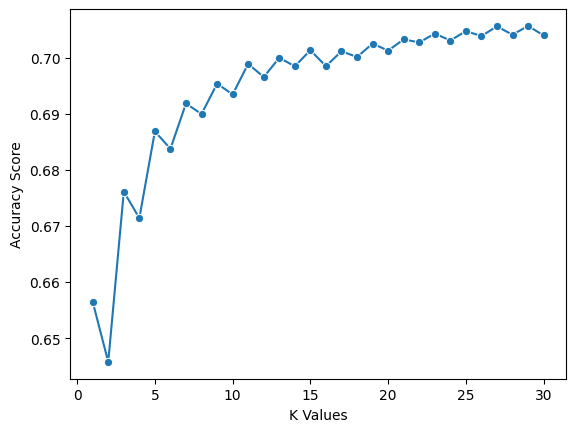

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

## Deep Learning Neural Network

In [ ]:
def accuracy_val(model):
    y_hat = model.predict(X_test)
    return float((sum((y_hat >= 0.5) == y_test)/len(y_test))[0])*100

In [ ]:
def accuracy_train(model):
    y_hat = model.predict(X_train)
    return float((sum((y_hat >= 0.5) == y_train)/len(y_train))[0])*100

In [ ]:
X.shape

(100000, 768)

In [ ]:
y = np.array(y)
y = y.reshape(-1, 1)
y.shape

(100000, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='gelu'))
model.add(Dense(512, activation='gelu'))
model.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7609 - loss: 0.4896 - val_accuracy: 0.8127 - val_loss: 0.4127
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8334 - loss: 0.3740 - val_accuracy: 0.8149 - val_loss: 0.4080
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8517 - loss: 0.3344 - val_accuracy: 0.8153 - val_loss: 0.4189
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8800 - loss: 0.2773 - val_accuracy: 0.8068 - val_loss: 0.4564
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9102 - loss: 0.2145 - val_accuracy: 0.8042 - val_loss: 0.5001
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9394 - loss: 0.1522 - val_accuracy: 0.8010 - val_loss: 0.6175
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9576 - loss: 0.1085 - val_accuracy: 0.7962 - val_loss: 0.7541
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9689 -

In [ ]:
import pydot

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
model.summary()
accuracy_val(model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,758,661 (10.52 MB)

 Trainable params: 919,553 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,839,108 (7.02 MB)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


78.85

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7130 - loss: 0.5588 - val_accuracy: 0.8058 - val_loss: 0.4271
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8048 - loss: 0.4271 - val_accuracy: 0.8176 - val_loss: 0.4155
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8212 - loss: 0.3989 - val_accuracy: 0.8231 - val_loss: 0.3978
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8267 - loss: 0.3874 - val_accuracy: 0.8240 - val_loss: 0.3948
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8325 - loss: 0.3719 - val_accuracy: 0.8224 - val_loss: 0.3954
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8387 - loss: 0.3613 - val_accuracy: 0.8251 - val_loss: 0.3955
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8433 - loss: 0.3532 - val_accuracy: 0.8257 - val_loss: 0.3930
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8433 - loss: 0.3479 - 

In [ ]:
accuracy_val(model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.435

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model0 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model0.add(Dense(512, input_dim=768, activation='gelu'))
model0.add(Dropout(0.3))  # Dropout to prevent overfitting
model0.add(Dense(256, activation='gelu'))
model0.add(Dropout(0.3))
model0.add(Dense(128, activation='gelu'))
model0.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model0.add(Dense(1, activation='sigmoid'))

# Compile the model
model0.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7216 - loss: 0.5441 - val_accuracy: 0.8058 - val_loss: 0.4224
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8119 - loss: 0.4149 - val_accuracy: 0.8148 - val_loss: 0.4101
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8225 - loss: 0.3928 - val_accuracy: 0.8184 - val_loss: 0.4017
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8317 - loss: 0.3803 - val_accuracy: 0.8236 - val_loss: 0.3959
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8382 - loss: 0.3639 - val_accuracy: 0.8216 - val_loss: 0.3943
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8440 - loss: 0.3481 - val_accuracy: 0.8250 - val_loss: 0.3966
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8474 - loss: 0.3422 - val_accuracy: 0.8266 - val_loss: 0.3900
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8507 -

In [ ]:
accuracy_val(model0)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.12

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model1 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model1.add(Dense(512, input_dim=768, activation='relu'))
model1.add(Dropout(0.3))  # Dropout to prevent overfitting
model1.add(Dense(256, activation='gelu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='mish'))
model1.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7210 - loss: 0.5482 - val_accuracy: 0.8056 - val_loss: 0.4248
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8056 - loss: 0.4224 - val_accuracy: 0.8114 - val_loss: 0.4115
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8237 - loss: 0.3974 - val_accuracy: 0.8223 - val_loss: 0.3963
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8285 - loss: 0.3796 - val_accuracy: 0.8238 - val_loss: 0.3926
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8400 - loss: 0.3645 - val_accuracy: 0.8241 - val_loss: 0.3939
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8426 - loss: 0.3563 - val_accuracy: 0.8201 - val_loss: 0.3986
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8473 - loss: 0.3473 - val_accuracy: 0.8208 - val_loss: 0.3971
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8453 - loss: 0.3456 -

In [ ]:
accuracy_val(model1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.17999999999999

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model2 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model2.add(Dense(512, input_dim=768, activation='gelu'))
model2.add(Dropout(0.3))  # Dropout to prevent overfitting
model2.add(Dense(256, activation='gelu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='gelu'))
model2.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7301 - loss: 0.5375 - val_accuracy: 0.8057 - val_loss: 0.4284
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8097 - loss: 0.4246 - val_accuracy: 0.8198 - val_loss: 0.4041
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8206 - loss: 0.4007 - val_accuracy: 0.8215 - val_loss: 0.4004
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8287 - loss: 0.3810 - val_accuracy: 0.8191 - val_loss: 0.4004
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8340 - loss: 0.3731 - val_accuracy: 0.8244 - val_loss: 0.3971
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8382 - loss: 0.3649 - val_accuracy: 0.8248 - val_loss: 0.3939
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8403 - loss: 0.3587 - val_accuracy: 0.8248 - val_loss: 0.4017
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8461 - 

In [ ]:
accuracy_val(model2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.23

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model3 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model3.add(Dense(512, input_dim=768, activation='gelu'))
model3.add(Dense(512, input_dim=768, activation='mish'))
model3.add(Dropout(0.3))  # Dropout to prevent overfitting
model3.add(Dense(256, activation='gelu'))
model3.add(Dense(256, activation='tanh'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='gelu'))
model3.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8534 - loss: 0.3236 - val_accuracy: 0.8224 - val_loss: 0.4067
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8581 - loss: 0.3168 - val_accuracy: 0.8227 - val_loss: 0.4177
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8617 - loss: 0.3028 - val_accuracy: 0.8224 - val_loss: 0.4102
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8643 - loss: 0.3015 - val_accuracy: 0.8223 - val_loss: 0.4149
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8663 - loss: 0.2947 - val_accuracy: 0.8223 - val_loss: 0.4121
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8694 - loss: 0.2871 - val_accuracy: 0.8247 - val_loss: 0.4298
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8725 - loss: 0.2827 - val_accuracy: 0.8207 - val_loss: 0.4218
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8779 -

In [ ]:
accuracy_val(model3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


50.27

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model4 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model4.add(Dense(512, input_dim=768, activation='mish'))
model4.add(Dropout(0.3))  # Dropout to prevent overfitting
model4.add(Dense(256, activation='tanh'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='gelu'))
model4.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7386 - loss: 0.5303 - val_accuracy: 0.8136 - val_loss: 0.4111
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8121 - loss: 0.4143 - val_accuracy: 0.8164 - val_loss: 0.4088
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8241 - loss: 0.3945 - val_accuracy: 0.8139 - val_loss: 0.4076
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8269 - loss: 0.3862 - val_accuracy: 0.8189 - val_loss: 0.4004
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8303 - loss: 0.3757 - val_accuracy: 0.8151 - val_loss: 0.4056
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8343 - loss: 0.3671 - val_accuracy: 0.8220 - val_loss: 0.3981
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8405 - loss: 0.3606 - val_accuracy: 0.8256 - val_loss: 0.3934
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8425 -

In [ ]:
accuracy_val(model4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.645

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model5 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model5.add(Dense(64, input_dim=768, activation='mish'))
model5.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7201 - loss: 0.5511 - val_accuracy: 0.8069 - val_loss: 0.4250
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8054 - loss: 0.4245 - val_accuracy: 0.8176 - val_loss: 0.4071
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8164 - loss: 0.4052 - val_accuracy: 0.8220 - val_loss: 0.4025
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8237 - loss: 0.3934 - val_accuracy: 0.8209 - val_loss: 0.3978
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8268 - loss: 0.3862 - val_accuracy: 0.8234 - val_loss: 0.3950
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8344 - loss: 0.3725 - val_accuracy: 0.8246 - val_loss: 0.3916
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8356 - loss: 0.3716 - val_accuracy: 0.8240 - val_loss: 0.3937
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8386 - loss: 0.3659 - 

In [ ]:
accuracy_val(model5)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step


82.635

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model6 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model6.add(Dense(64, input_dim=768, activation='gelu'))
model6.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7149 - loss: 0.5694 - val_accuracy: 0.8024 - val_loss: 0.4248
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8062 - loss: 0.4229 - val_accuracy: 0.8157 - val_loss: 0.4040
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8187 - loss: 0.4016 - val_accuracy: 0.8184 - val_loss: 0.4012
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8238 - loss: 0.3914 - val_accuracy: 0.8199 - val_loss: 0.3973
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8302 - loss: 0.3826 - val_accuracy: 0.8252 - val_loss: 0.3955
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8363 - loss: 0.3734 - val_accuracy: 0.8234 - val_loss: 0.3933
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8388 - loss: 0.3673 - val_accuracy: 0.8234 - val_loss: 0.3934
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8403 - loss: 0.3623 - 

In [ ]:
accuracy_val(model6)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step


82.54

In [ ]:
from tensorflow.keras.regularizers import l1_l2

model7 = Sequential()
model7.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model7.add(Dropout(0.3))  # Dropout to prevent overfitting
model7.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6357 - loss: 2.6623 - val_accuracy: 0.7239 - val_loss: 0.7085
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7022 - loss: 0.7000 - val_accuracy: 0.7596 - val_loss: 0.6519
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7220 - loss: 0.6770 - val_accuracy: 0.7643 - val_loss: 0.6341
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7210 - loss: 0.6713 - val_accuracy: 0.7624 - val_loss: 0.6363
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7262 - loss: 0.6660 - val_accuracy: 0.7722 - val_loss: 0.6255
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7271 - loss: 0.6613 - val_accuracy: 0.7646 - val_loss: 0.6223
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7284 - loss: 0.6590 - val_accuracy: 0.7658 - val_loss: 0.6230
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7292 - loss: 0.6543 - 

In [ ]:
accuracy_val(model7)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step


77.335

In [ ]:
model8 = Sequential()
model8.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6037 - loss: 3.1519 - val_accuracy: 0.7174 - val_loss: 0.7680
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6447 - loss: 0.7463 - val_accuracy: 0.7380 - val_loss: 0.6966
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6474 - loss: 0.7125 - val_accuracy: 0.7521 - val_loss: 0.6841
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6556 - loss: 0.7064 - val_accuracy: 0.7613 - val_loss: 0.6728
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6569 - loss: 0.7033 - val_accuracy: 0.7432 - val_loss: 0.6761
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6596 - loss: 0.6994 - val_accuracy: 0.7517 - val_loss: 0.6651
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6630 - loss: 0.6977 - val_accuracy: 0.7578 - val_loss: 0.6637
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6614 - loss: 0.6957 - 

In [ ]:
accuracy_val(model8)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step


75.305

In [ ]:
model9 = Sequential()
model9.add(Dense(16, input_dim=768, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model9.add(Dropout(0.3))  # Dropout to prevent overfitting
model9.add(Dense(16, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6171 - loss: 2.6048 - val_accuracy: 0.7281 - val_loss: 0.6843
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6658 - loss: 0.6876 - val_accuracy: 0.7517 - val_loss: 0.6454
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6784 - loss: 0.6715 - val_accuracy: 0.7663 - val_loss: 0.6289
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6832 - loss: 0.6645 - val_accuracy: 0.7709 - val_loss: 0.6229
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6839 - loss: 0.6616 - val_accuracy: 0.7688 - val_loss: 0.6198
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6826 - loss: 0.6592 - val_accuracy: 0.7646 - val_loss: 0.6173
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6853 - loss: 0.6564 - val_accuracy: 0.7752 - val_loss: 0.6126
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6857 - loss: 0.6533 - 

In [ ]:
accuracy_val(model9)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step


77.325

In [ ]:
model10 = Sequential()
model10.add(Dense(16, input_dim=768, activation='gelu'))
model10.add(Dropout(0.3))  # Dropout to prevent overfitting
model10.add(Dense(16, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model10.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model10)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6844 - loss: 0.5850 - val_accuracy: 0.7935 - val_loss: 0.4410
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7904 - loss: 0.4478 - val_accuracy: 0.8135 - val_loss: 0.4131
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8083 - loss: 0.4227 - val_accuracy: 0.8149 - val_loss: 0.4063
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8130 - loss: 0.4146 - val_accuracy: 0.8199 - val_loss: 0.4001
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8168 - loss: 0.4073 - val_accuracy: 0.8233 - val_loss: 0.3973
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8191 - loss: 0.4044 - val_accuracy: 0.8235 - val_loss: 0.3980
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8227 - loss: 0.3962 - val_accuracy: 0.8243 - val_loss: 0.3935
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8249 - loss: 0.3921 - 

82.31

In [ ]:
model11 = Sequential()
model11.add(Dense(16, input_dim=768, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(8, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model
model11.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model11.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model11)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6153 - loss: 0.6815 - val_accuracy: 0.7717 - val_loss: 0.5065
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7613 - loss: 0.5120 - val_accuracy: 0.8008 - val_loss: 0.4427
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7936 - loss: 0.4584 - val_accuracy: 0.8113 - val_loss: 0.4224
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7997 - loss: 0.4433 - val_accuracy: 0.8139 - val_loss: 0.4123
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8065 - loss: 0.4324 - val_accuracy: 0.8188 - val_loss: 0.4102
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8119 - loss: 0.4207 - val_accuracy: 0.8172 - val_loss: 0.4108
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8108 - loss: 0.4195 - val_accuracy: 0.8187 - val_loss: 0.4027
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8149 - loss: 0.4120 - 

82.1

In [ ]:
model12 = Sequential()
model12.add(Dense(16, input_dim=768, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(8, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model
model12.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model12.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model12)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6551 - loss: 0.6290 - val_accuracy: 0.7900 - val_loss: 0.4552
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7814 - loss: 0.4777 - val_accuracy: 0.8086 - val_loss: 0.4179
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8026 - loss: 0.4428 - val_accuracy: 0.8118 - val_loss: 0.4106
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8091 - loss: 0.4322 - val_accuracy: 0.8173 - val_loss: 0.4037
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8126 - loss: 0.4255 - val_accuracy: 0.8190 - val_loss: 0.4012
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8187 - loss: 0.4138 - val_accuracy: 0.8233 - val_loss: 0.3966
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8179 - loss: 0.4149 - val_accuracy: 0.8227 - val_loss: 0.3969
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8218 - loss: 0.4074 - 

82.37

In [ ]:
model13 = Sequential()
model13.add(Dense(16, input_dim=768, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(8, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model13.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model13)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5525 - loss: 0.7209 - val_accuracy: 0.6872 - val_loss: 0.6165
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6574 - loss: 0.6282 - val_accuracy: 0.7325 - val_loss: 0.5505
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7091 - loss: 0.5752 - val_accuracy: 0.7598 - val_loss: 0.5038
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7395 - loss: 0.5301 - val_accuracy: 0.7803 - val_loss: 0.4715
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7637 - loss: 0.4997 - val_accuracy: 0.7914 - val_loss: 0.4509
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7757 - loss: 0.4851 - val_accuracy: 0.7987 - val_loss: 0.4366
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7892 - loss: 0.4646 - val_accuracy: 0.8069 - val_loss: 0.4262
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7982 - loss: 0.4523 - 

81.39999999999999

In [ ]:
model14 = Sequential()
model14.add(Dense(8, input_dim=768, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model14.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model14)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6025 - loss: 0.6637 - val_accuracy: 0.7719 - val_loss: 0.5302
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7345 - loss: 0.5649 - val_accuracy: 0.8046 - val_loss: 0.4682
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7793 - loss: 0.5122 - val_accuracy: 0.8102 - val_loss: 0.4400
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7905 - loss: 0.4881 - val_accuracy: 0.8154 - val_loss: 0.4254
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7993 - loss: 0.4707 - val_accuracy: 0.8191 - val_loss: 0.4154
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8018 - loss: 0.4648 - val_accuracy: 0.8193 - val_loss: 0.4136
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8053 - loss: 0.4549 - val_accuracy: 0.8209 - val_loss: 0.4084
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8058 - loss: 0.4513 - 

81.97

In [ ]:
model15 = Sequential()
model15.add(Dense(4, input_dim=768, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model15.add(Dense(1, activation='sigmoid'))

# Compile the model
model15.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model15.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model15)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5993 - loss: 0.6587 - val_accuracy: 0.7831 - val_loss: 0.4912
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7378 - loss: 0.5500 - val_accuracy: 0.8035 - val_loss: 0.4424
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7709 - loss: 0.5143 - val_accuracy: 0.8128 - val_loss: 0.4240
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7878 - loss: 0.4927 - val_accuracy: 0.8132 - val_loss: 0.4206
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7954 - loss: 0.4803 - val_accuracy: 0.8183 - val_loss: 0.4168
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7952 - loss: 0.4748 - val_accuracy: 0.8214 - val_loss: 0.4105
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7986 - loss: 0.4680 - val_accuracy: 0.8186 - val_loss: 0.4114
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8007 - loss: 0.4636 - 

81.89999999999999

In [ ]:
model16 = Sequential()
model16.add(Dense(16, input_dim=768, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(8, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model16.add(Dense(1, activation='sigmoid'))

# Compile the model
model16.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
accuracy_val(model16)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5595 - loss: 0.7511 - val_accuracy: 0.6811 - val_loss: 0.6261
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6573 - loss: 0.6388 - val_accuracy: 0.7297 - val_loss: 0.5810
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6991 - loss: 0.5994 - val_accuracy: 0.7540 - val_loss: 0.5341
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7300 - loss: 0.5560 - val_accuracy: 0.7701 - val_loss: 0.4915
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7519 - loss: 0.5220 - val_accuracy: 0.7845 - val_loss: 0.4646
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7673 - loss: 0.4988 - val_accuracy: 0.7949 - val_loss: 0.4468
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7790 - loss: 0.4781 - val_accuracy: 0.8004 - val_loss: 0.4336
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7853 - loss: 0

81.86

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model17 = Sequential()
model17.add(Dense(16, input_dim=768, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(8, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model17.add(Dense(1, activation='sigmoid'))

# Compile the model
model17.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model17.fit(X_train, y_train, epochs=52, batch_size=64, validation_split=0.2)
accuracy_val(model17)

Epoch 1/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5504 - loss: 0.6964 - val_accuracy: 0.6741 - val_loss: 0.6449
Epoch 2/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6618 - loss: 0.6362 - val_accuracy: 0.7286 - val_loss: 0.5798
Epoch 3/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7120 - loss: 0.5810 - val_accuracy: 0.7583 - val_loss: 0.5209
Epoch 4/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7453 - loss: 0.5335 - val_accuracy: 0.7795 - val_loss: 0.4850
Epoch 5/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7619 - loss: 0.5072 - val_accuracy: 0.7891 - val_loss: 0.4602
Epoch 6/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7808 - loss: 0.4812 - val_accuracy: 0.7977 - val_loss: 0.4450
Epoch 7/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7880 - loss: 0.4672 - val_accuracy: 0.8033 - val_loss: 0.4351
Epoch 8/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7937 - loss: 0.4591 - 

82.28999999999999

In [ ]:
model18 = Sequential()
model18.add(Dense(16, input_dim=768, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(8, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model18.add(Dense(1, activation='sigmoid'))

# Compile the model
model18.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model18)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5470 - loss: 0.6854 - val_accuracy: 0.6979 - val_loss: 0.6269
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6766 - loss: 0.6199 - val_accuracy: 0.7434 - val_loss: 0.5415
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7212 - loss: 0.5608 - val_accuracy: 0.7691 - val_loss: 0.4984
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7432 - loss: 0.5262 - val_accuracy: 0.7837 - val_loss: 0.4710
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7628 - loss: 0.4996 - val_accuracy: 0.7940 - val_loss: 0.4533
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7757 - loss: 0.4830 - val_accuracy: 0.8002 - val_loss: 0.4415
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7828 - loss: 0.4738 - val_accuracy: 0.8045 - val_loss: 0.4322
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7944 - loss: 0

82.26

In [ ]:
models = [model, model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17, model18, modeli]

In [ ]:
model_results = []

for Model in models:
    model_results.append((Model.count_params(), accuracy_val(Model)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


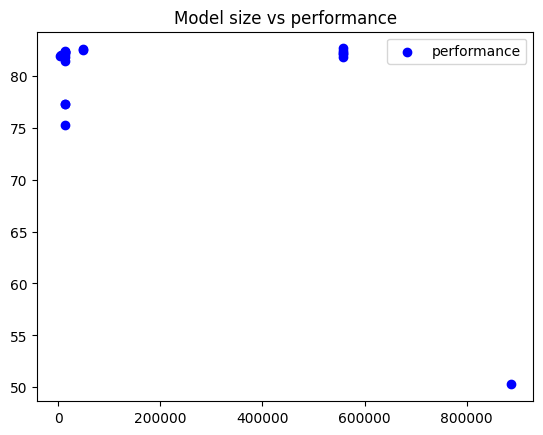

In [ ]:
x,y = [], []

for Model in model_results:
    x.append(Model[0])
    y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


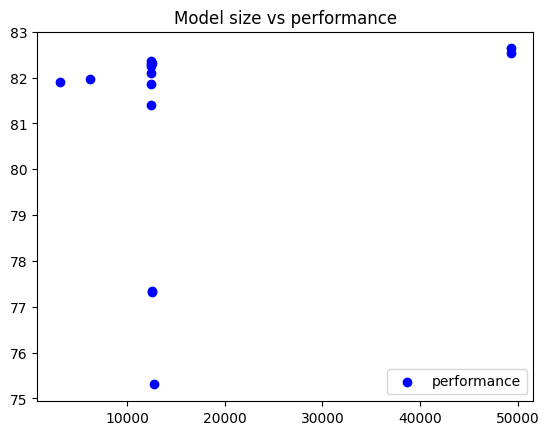

In [ ]:
x,y = [], []

for Model in model_results:
    if (Model[0] < 100000):
        x.append(Model[0])
        y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


In [ ]:
model_results

[(558081, 82.435),
 (558081, 82.12),
 (558081, 82.17999999999999),
 (558081, 81.815),
 (886529, 50.27),
 (558081, 82.645),
 (49281, 82.635),
 (49281, 82.54),
 (12593, 77.335),
 (12721, 75.305),
 (12593, 77.325),
 (12593, 82.31),
 (12481, 82.1),
 (12481, 82.37),
 (12481, 81.39999999999999),
 (6221, 81.97),
 (3149, 81.89999999999999),
 (12481, 81.86),
 (12481, 82.28999999999999),
 (12481, 82.26)]

In [ ]:
model_family = []

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(512, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6405 - loss: 0.6299 - val_accuracy: 0.7873 - val_loss: 0.4576
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7724 - loss: 0.4787 - val_accuracy: 0.8081 - val_loss: 0.4181
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8055 - loss: 0.4316 - val_accuracy: 0.8139 - val_loss: 0.4090
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8152 - loss: 0.4092 - val_accuracy: 0.8197 - val_loss: 0.3976
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8275 - loss: 0.3920 - val_accuracy: 0.8232 - val_loss: 0.3942
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8299 - loss: 0.3831 - val_accuracy: 0.8259 - val_loss: 0.3916
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8378 - loss: 0.3681 - val_accuracy: 0.8254 - val_loss: 0.3897
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8414 -

82.34

In [ ]:
model_family.append(modeli)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(256, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6159 - loss: 0.6571 - val_accuracy: 0.7678 - val_loss: 0.4872
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7593 - loss: 0.5025 - val_accuracy: 0.7991 - val_loss: 0.4347
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7923 - loss: 0.4523 - val_accuracy: 0.8106 - val_loss: 0.4160
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8089 - loss: 0.4274 - val_accuracy: 0.8184 - val_loss: 0.4032
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8107 - loss: 0.4178 - val_accuracy: 0.8191 - val_loss: 0.3979
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8224 - loss: 0.4007 - val_accuracy: 0.8225 - val_loss: 0.3949
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8266 - loss: 0.3911 - val_accuracy: 0.8234 - val_loss: 0.3916
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8340 - loss: 0.3773 - 

82.44500000000001

### Results

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


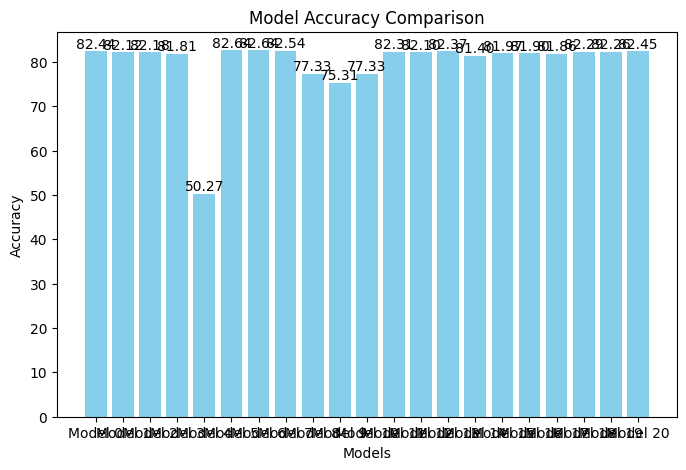

In [ ]:
# Given list of models
models = [model, model0, model1, model2, model3, 
          model4, model5, model6, model7, model8, 
          model9, model10, model11, model12, model13, 
          model14, model15, model16, model17, model18, 
          modeli]

# Compute accuracy values
accuracies = [accuracy_val(m) for m in models]

# Generate model names as labels
model_names = [f"Model {i}" for i in range(len(models))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

# Display the plot
plt.show()


### Drop 5th, 9th, 10th, 11th models

In [ ]:
# Given list of models
models = [model, model0, model1, model2, model10, model11, 
          model12, model13, model14, model15, model16, model17, 
          model18, modeli]

# Compute accuracy per parameter values
accuracy_efficiencies = [accuracy_val(m)/(m.count_params()) for m in models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(models))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy per Parameter")
plt.title("Model Accuracy Efficiency Comparison")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom')

# Display the plot
plt.show()


NameError: name 'model0' is not defined

In [ ]:
accuracy_train(model15)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


82.4325

In [ ]:
(model15.count_params(), accuracy_val(model15))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(3149, 81.89999999999999)

## K-Means++ & Deep Learning Neural Network

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    
    # Compute WSS
    WSS = np.sum((X - centers[position])**2)
    
    return position, centers, WSS

In [25]:
cluster_assignments = {}  # Dictionary to store assigned data points

wss_values = []  # Store WSS for each k
k_values = list(range(1, 11))  # k from 1 to 30

for k in k_values:
    print(f"at {k} k-value now")
    position, centers, WSS = sklearnKmeans_plus(X_train, k, 1000)
    
    # Store the WSS value for plotting
    wss_values.append(WSS)

    # Store cluster assignments (optional for later)
    cluster_assignments[k] = {
        "positions": position,
        "centers": centers,
        "WSS": WSS
    }


at 1 k-value now
at 2 k-value now
at 3 k-value now
at 4 k-value now
at 5 k-value now
at 6 k-value now
at 7 k-value now
at 8 k-value now
at 9 k-value now
at 10 k-value now


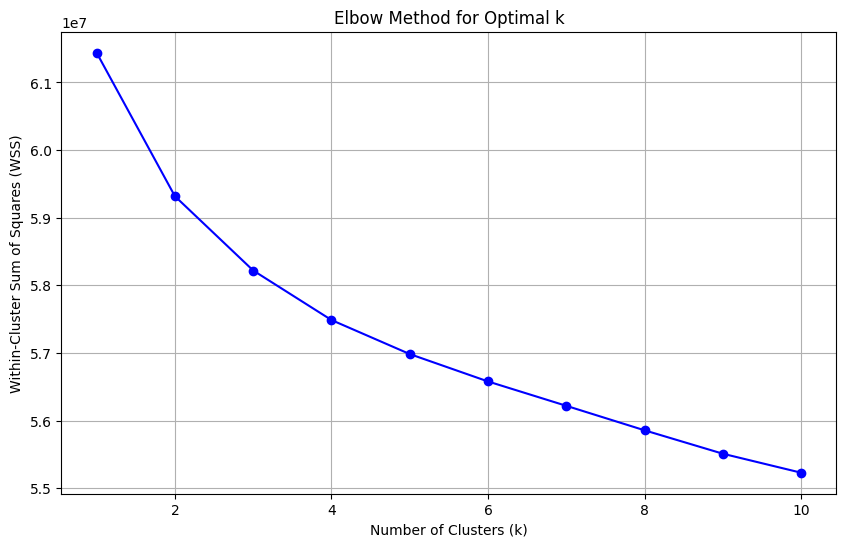

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

plt.show()

Optimal k found at: 4


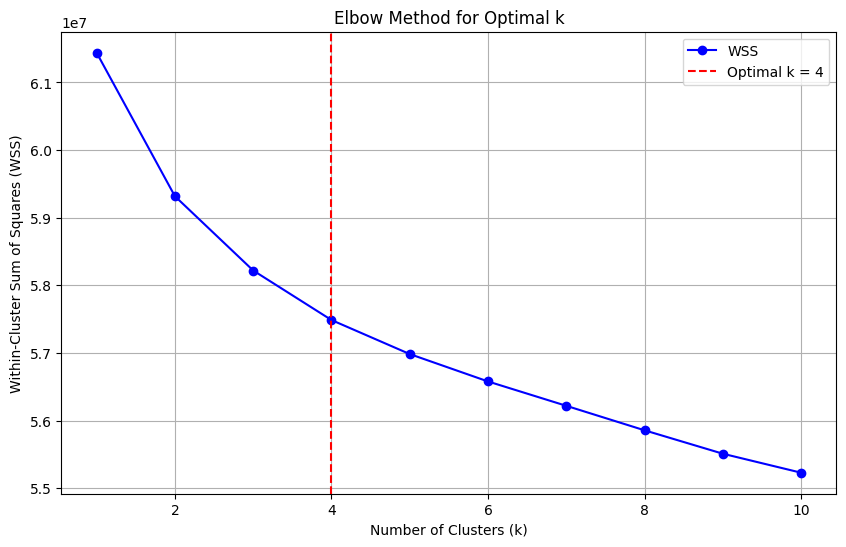

In [27]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, wss_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal k found at: {optimal_k}")

# Plot again with optimal k highlighted
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b', label="WSS")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)

plt.show()


In [29]:

def train_dnn(X, Y, position, cluster):
    # Create a mask where the position matches the index
    mask = (position == cluster)

    # Apply mask to keep only the relevant Y values
    y_train = Y[mask]
    X_train = X[mask]
    
    # Remove zero entries
    X_train = X_train[~np.all(X_train == 0, axis=1)]
    y_train = y_train[~np.all(X_train == 0, axis=1)]  # Ensure y_train is aligned



    new_model = Sequential()
    new_model.add(Dense(4, input_dim=768, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    new_model.add(Dense(4, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    new_model.add(Dense(2, activation='mish'))

    # Output layer: single neuron with sigmoid activation for binary classification
    new_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    new_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=100,  # Number of epochs to wait before stopping if no improvement
                                   restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                   verbose=1)

    # Train the model
    new_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    return new_model

In [30]:
optimal_cluster = cluster_assignments[optimal_k]['positions']
optimal_cluster

array([1, 2, 1, ..., 2, 0, 3], dtype=int32)

In [31]:
count = [i for i in range(4)]
for i in range(4):
    count[i] = int(sum(optimal_cluster == i))
count

[22659, 13996, 24339, 19006]

In [32]:
cluster_models = {}  # Dictionary to store cluster-wise DNN models

# Train a separate Deep Neural Network for each cluster
for cluster in range(4):
    cluster_models[cluster] = train_dnn(X_train, y_train, optimal_cluster, cluster)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5672 - loss: 0.6814 - val_accuracy: 0.7026 - val_loss: 0.6273
Epoch 2/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6653 - loss: 0.6220 - val_accuracy: 0.7436 - val_loss: 0.5515
Epoch 3/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7015 - loss: 0.5684 - val_accuracy: 0.7822 - val_loss: 0.4882
Epoch 4/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7272 - loss: 0.5209 - val_accuracy: 0.7935 - val_loss: 0.4544
Epoch 5/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - loss: 0.4942 - val_accuracy: 0.8001 - val_loss: 0.4351
Epoch 6/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7740 - loss: 0.4712 - val_accuracy: 0.8140 - val_loss: 0.4249
Epoch 7/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7841 - loss: 0.4602 - val_accuracy: 0.8133 - val_loss: 0.4151
Epoch 8/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7978 - loss: 0.4456 - val_accu

### Inner Cluster Model Evaluation

In [33]:
cluster_models

{0: <Sequential name=sequential, built=True>,
 1: <Sequential name=sequential_1, built=True>,
 2: <Sequential name=sequential_2, built=True>,
 3: <Sequential name=sequential_3, built=True>}

In [34]:
cluster_models[2].count_params()

3109

In [35]:
k_values = [i for i in range(1, 12, 2)]
scores = []

for k in k_values:
    print(f"at {k} k-value now")
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, optimal_cluster, cv=5)
    scores.append(np.mean(score))

at 1 k-value now
at 3 k-value now
at 5 k-value now
at 7 k-value now
at 9 k-value now
at 11 k-value now


Text(0, 0.5, 'Cross-Validation Score')

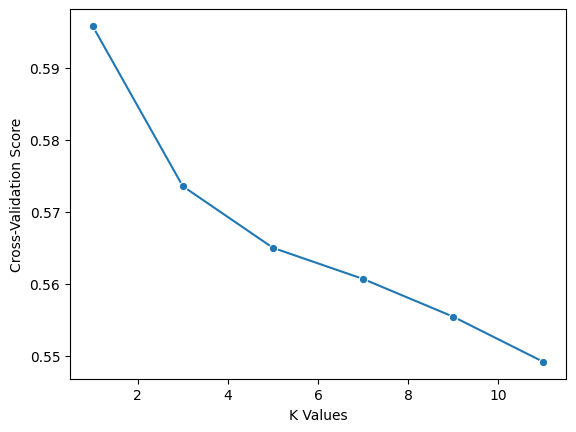

In [36]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [37]:
optimal_kneighbour = k_values[scores.index(max(scores))]

In [38]:
knn = KNeighborsClassifier(n_neighbors=optimal_kneighbour)
knn.fit(X_train, optimal_cluster)
cluser_hat = knn.predict(X_test)

In [39]:
N = len(y_test)
N

20000

In [40]:
cluser_hat[0]

np.int32(0)

In [41]:
X_test[0].shape

(768,)

In [42]:

y_hat = [0 for i in range(N)]

for i in range(len(X_test)):
    x_i = X_test[i]
    cluster = cluser_hat[i]
    model = cluster_models[cluster]
    y_hat[i] = model.predict(np.array([x_i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [58]:
y_pred = np.array(list(map(lambda x: x[0][0], y_hat)))

In [64]:
float((sum((y_pred >= 0.5) == y_test)/len(y_test)))*100

80.235